In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

## Simulation Model

In [2]:
class Model():
    T = 1
    moveMat = np.eye(4)
    moveMat[0,1]=moveMat[2,3]=T # matrix updating target state
    tau = np.array(((T**2/2,0),(T,0),(0,T**2/2),(0,T)))
    
    def __init__(self,N):
        self.N = N
        self.x = np.zeros((4,N))
        self.z = np.zeros(N)
        
    def randomizeInit(self, w):
        self.x[:,0] = np.random.randn(4)+1
        self.z[0] = np.arctan(self.x[2,0]/self.x[0,0]+1e-8) + w[0]
    def forward(self,x_last,u_curr=np.zeros(2)):
        return Model.moveMat@x_last + Model.tau@u_curr
    def observe(self,x_curr,w_curr=0):
        return np.arctan(x_curr[2]/(x_curr[0]+1e-8))+w_curr        
    def iterateForward(self, u, w):
        self.randomizeInit(w)
        for i in range(1,self.N):
            self.x[:,i] = self.forward(self.x[:,i-1],u[:,i])
            self.z[i] = self.observe(self.x[:,i],w[i])
    def visualize(self, type):
        if type == 'ground-truth':
            plt.plot(self.x[0,:],self.x[2,:])
            plt.title(type)
        elif type == 'observation':
            plt.plot(range(N),self.z)
            plt.title(type)
        else:
            print("please choose from 'ground-truth' and 'observation'")
            pass

In [3]:
N = int(1e2) # Time period
T = 1 # sampling period
sig_u = 0.5 # std of system noise
mean_u = [0,0] # mean of system noise
sig_w = 0.1 # std of measurement noise
mean_w = 0 # mean of measurement noise
u = np.random.multivariate_normal(mean_u,sig_u**2*np.eye(2),(N)).T
w = np.random.normal(mean_w, sig_w,(N))

In [4]:
sim = Model(N)
sim.iterateForward(u,w)

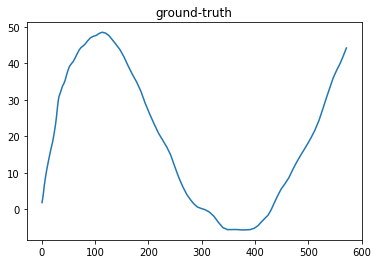

In [5]:
sim.visualize('ground-truth')

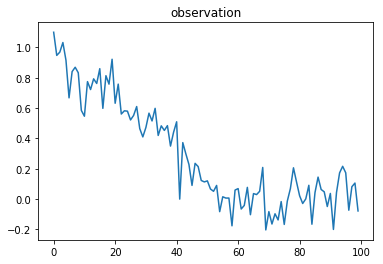

In [6]:
sim.visualize('observation')

## Extended Kalman Filter

In [88]:
class extendedKalmanFilter(Model):
    def __init__(self, model):
        super(extendedKalmanFilter,self).__init__(model.N)
        self.x = model.x
        self.z = model.z
        self.x_est = np.zeros((4,self.N))
        self.x_est_cont = np.zeros((4,self.N))
        self.x_est[:,0] = np.ones(4)
    def initPQR(self,sig_u,sig_w):
        self.P = [np.eye(4)]*self.N
        self.Q = np.diag((sig_u,sig_u))**2
        self.R = sig_w**2
    def predict(self,i):        
        self.x_est_cont[:,i] = self.forward(self.x_est[:,i-1])
        P_cont = Model.moveMat@self.P[i-1]@Model.moveMat.T
        H = self.JacobianObserve(self.x_est[:,i-1])
        K = P_cont@H.T/(H@P_cont@H.T+self.R)
        temp = (self.x_est_cont[:,i]+K*(self.z[i]-self.observe(self.x_est_cont[:,i]),))
        self.x_est[:,i] = [temp[i][0] for i in range(len(temp))]
        self.P[i] = (self.P[i]-K@H)@P_cont
    def predictIter(self):
        for i in range(1,N):
            self.predict(i)
    def JacobianObserve(self,x_last):
        x = x_last[0]
        y = x_last[2]
        H = np.zeros((1,4))        
        H[0,0] = -y/(1+x**2)
        H[0,2] = 1/x/(1+y**2)
        return H
    def visual_est(self):
        print(self.x_est[0].shape)
        plt.plot(self.x_est[0],self.x_est[2])

In [89]:
ekf = extendedKalmanFilter(sim)
ekf.initPQR(sig_u,sig_w)

In [90]:
ekf.predictIter()

(100,)


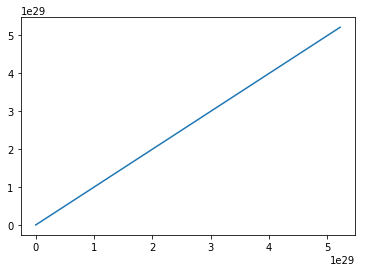

In [91]:
ekf.visual_est()

## Particle Filter

In [79]:
class particleFilter(Model):
    def __init__(self,model,M):
        super(particleFilter,self).__init__(model.N)
        self.M = M
        self.x_est = np.zeros((4,self.N))
        self.x = model.x
        self.z = model.z
    def initEst(self):
        self.x_est[:,0] = np.ones(4)
    def predict(self,i,sig_u,sig_w):
        x_est_cont = np.zeros((4,self.M))
        likelihood = np.zeros(self.M)
        for m in range(self.M):
            u_tmp = np.random.multivariate_normal(mean_u,sig_u**2*np.eye(2)).T
            x_est_cont[:,m] = self.forward(self.x_est[:,i-1],u_tmp)
            likelihood[m] = self.calLikelihood(x_est_cont[:,m],i,sig_w)
        likelihood /= sum(likelihood)
        sampled_est = np.zeros((4,self.M))
        for m in range(self.M):
            index = generateRand(likelihood, len(likelihood))
            sampled_est[:,m] = x_est_cont[:,index]
        self.x_est[:,i] = np.mean(sampled_est,1)
    def predictIter(self,sig_u,sig_w):
        for i in range(1,N):
            self.predict(i,sig_u,sig_w)
    def calLikelihood(self,x_est_cont_m,i,sig_w):
        measure_noise = self.z[i] - self.observe(x_est_cont_m)
        likelihood = scipy.stats.norm.pdf(measure_noise,loc=0,scale=sig_w**2)
        return likelihood
    def visual_est(self):
        print(self.x_est[0].shape)
        plt.plot(self.x_est[0],self.x_est[2])

In [80]:
def generateRand(probability, stateNum):
    c = max(probability)*stateNum
    y = np.random.randint(0,stateNum)
    u = np.random.rand()
    while u>= probability[y]/c/(1/stateNum):
        u = np.random.rand()
        y = np.random.randint(0,stateNum)
    return y
    

In [84]:
pf = particleFilter(sim,int(1e3))

In [85]:
pf.initEst()
pf.predictIter(sig_u,sig_w)

/Users/Ricardo/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


(100,)


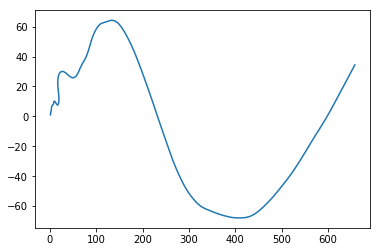

In [86]:
pf.visual_est()